# Meeting
* Members skills presentation
## What area is covered by sugar cane?
* Clouds? -- SCL help (1 person)
* Preprocessing
* Clustering
   + [Overview different algorithms](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)
   + [Performance evaluation](https://stats.stackexchange.com/questions/21807/evaluation-measures-of-goodness-or-validity-of-clustering-without-having-truth)
   + Performance in literature
* Time-depending ideas?
* Another approach?
* Expert (1 person)
* Time Series? (can be the expert)

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import xarray
import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
# read in the sentinel 2 data
s2_data = xarray.open_dataset('cali_training.nc')
s2_data

<xarray.Dataset>
Dimensions:      (band: 10, date: 26, x: 994, y: 940)
Coordinates:
  * band         (band) object 'B02' 'B03' 'B04' 'B05' ... 'B8A' 'B11' 'B12'
  * date         (date) datetime64[ns] 2016-12-18 2017-02-16 ... 2019-01-22
Dimensions without coordinates: x, y
Data variables:
    reflectance  (y, x, band, date) uint16 ...
    mask         (y, x) bool ...
    SCL          (y, x, date) uint16 ...
Attributes:
    transform:  [ 1.0000e+01  0.0000e+00  3.3092e+05  0.0000e+00 -1.0000e+01 ...
    crs:        +init=epsg:32618

In [3]:
band_dict = {k: v for v,k in enumerate(s2_data.band.values)}
date_dict = {str(k)[:10]: v for v,k in enumerate(s2_data.date.values)}

In [4]:
def image_histogram_equalization(image):
    """ Image histogram equlisation"""
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), 256, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (255-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
    if len(image.shape) == 3:
        return image_equalized.reshape(image.shape).astype('uint8')[:,:,::-1]
    else:
        return image_equalized.reshape(image.shape).astype('uint8')

In [5]:
w, h = s2_data.reflectance.isel(date=0, band=0).values.shape

def create_dataset(obj, d):
    try:
        l, = s2_data.band.values.shape
        return np.concatenate([obj.isel(date=d, band=b).values.reshape(w, h, 1) for b in range(l)], axis=-1)
    except:
        return obj.isel(date=d).values.reshape(w, h)

In [6]:
def add_feature(X, fea, ax=2):
    return np.concatenate((X, fea), axis=ax)

In [7]:
X_SCL_0 = create_dataset(s2_data.SCL, 0)

In [19]:
CLOUDS

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

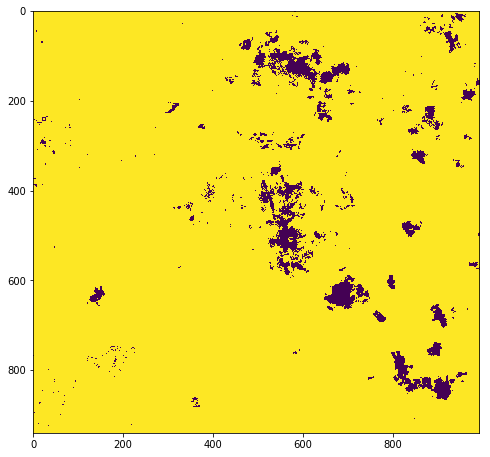

In [32]:
def CLOUDS(d):
    di = (create_dataset(s2_data.SCL, d) == 9) | (create_dataset(s2_data.SCL, d) == 8)
    dii = (create_dataset(s2_data.SCL, d+1) == 9) | (create_dataset(s2_data.SCL, d+1) == 8)
    return 1 - (di | dii).astype(np.uint8)
    
plt.figure(figsize=(8,8))
plt.imshow(CLOUDS(0))
plt.show()

In [134]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN

In [234]:
DATE = 1

def diff(d, dist=(lambda x, y: np.abs(x - y))):
    di = create_dataset(s2_data.reflectance, d)/10000
    r, ir = di[:,:,band_dict['B04']], di[:,:,band_dict['B08']]
    NVDI = ((ir-r)/(ir+r)).reshape(w, h, 1)
    di = add_feature(di, NVDI)
    dii = create_dataset(s2_data.reflectance, d+1)/10000
    r, ir = dii[:,:,band_dict['B04']], dii[:,:,band_dict['B08']]
    NVDI = ((ir-r)/(ir+r)).reshape(w, h, 1)
    dii = add_feature(dii, NVDI)
    return dist(di, dii) * CLOUDS(d).reshape(w, h, 1)

D_1 = diff(DATE)
X_refl_1 = create_dataset(s2_data.reflectance, 1)/10000

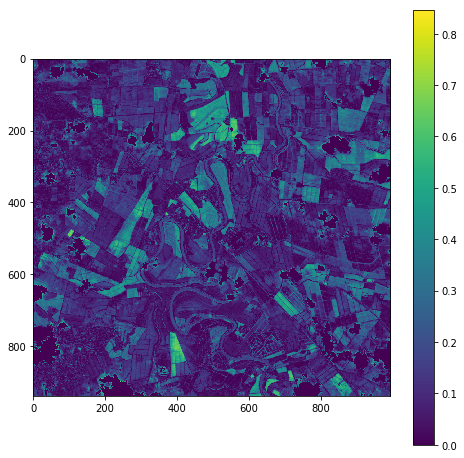

In [235]:
plt.figure(figsize=(8,8))
plt.imshow(D_1[:,:,10])
plt.colorbar()
plt.show()

In [236]:
D_1 = D_1.reshape(w * h, 11)

In [237]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(D_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [238]:
result = kmeans.predict(D_1).reshape(w, h)

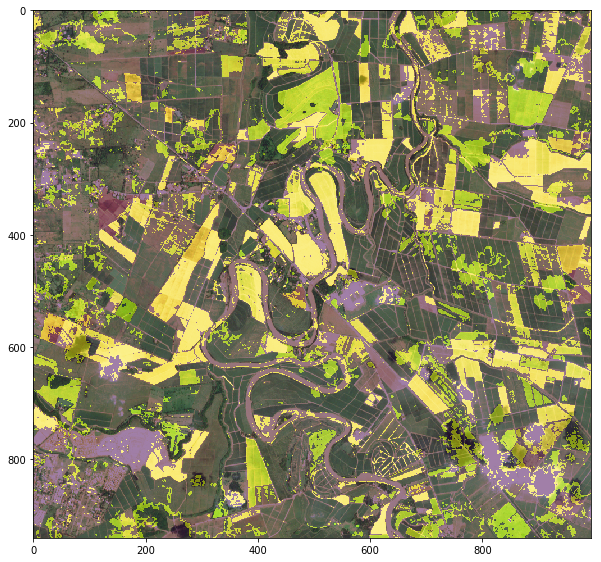

In [239]:
plt.figure(figsize=(10,10))
plt.imshow(image_histogram_equalization(X_refl_1[:,:,:3]))
plt.imshow(1-result, alpha=0.5)
plt.show()

In [ ]:
db = DBSCAN(eps=0.2, min_samples=10)
db.fit(D_1)

In [ ]:
result = db.predict(D_1).reshape(w, h)

plt.figure(figsize=(10,10))
plt.imshow(image_histogram_equalization(X_refl_1[:,:,:3]))
plt.imshow(1-result, alpha=0.5)
plt.show()

In [ ]:
def diff(d, dist=(lambda x, y: np.maximum(x, y))):
    di = create_dataset(s2_data.reflectance, d)/10000
    r, ir = di[:,:,band_dict['B04']], di[:,:,band_dict['B08']]
    NVDI = ((ir-r)/(ir+r)).reshape(w, h, 1)
    di = add_feature(di, NVDI)
    dii = create_dataset(s2_data.reflectance, d+1)/10000
    r, ir = dii[:,:,band_dict['B04']], dii[:,:,band_dict['B08']]
    NVDI = ((ir-r)/(ir+r)).reshape(w, h, 1)
    dii = add_feature(dii, NVDI)
    return dist(di, dii) * CLOUDS(d).reshape(w, h, 1)

D_inf = diff(DATE)
X_refl_inf = create_dataset(s2_data.reflectance, 1)/10000

plt.figure(figsize=(8,8))
plt.imshow(D_inf[:,:,10])
plt.colorbar()
plt.show()

D_inf = D_inf.reshape(w * h, 11)

In [241]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(D_inf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [242]:
result = kmeans.predict(D_inf).reshape(w, h)

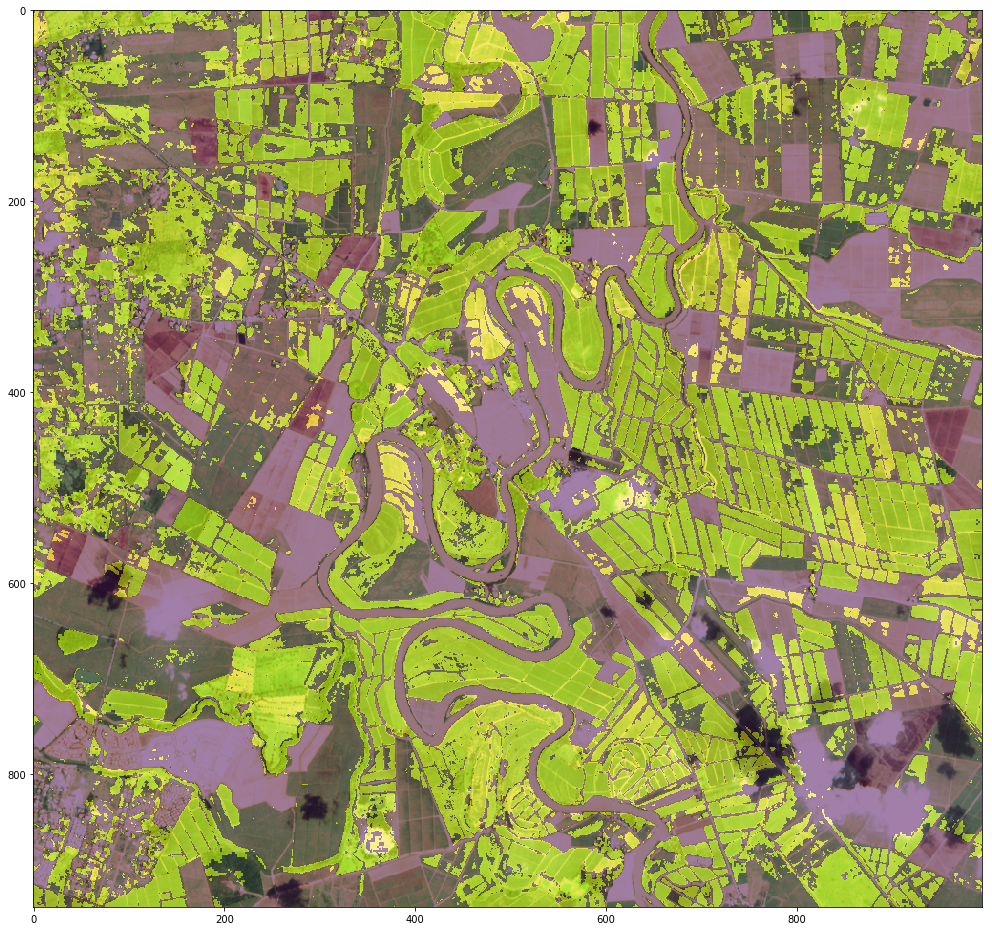

In [244]:
plt.figure(figsize=(17,17))
plt.imshow(image_histogram_equalization(X_refl_0[:,:,:3]))
plt.imshow(result==0, alpha=0.5)
plt.show()